In [1]:
# Daniel Bandala @ mar 2022
import random
import time
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
def readData(path,delimiter='tab'):
    '''
    Funcion leer un archivo y hacer la separacion por tabulador si el usuario ingresa 'tab' o coma ','
    Nota: No soporta UTF-8
    
    Inputs:
    paht: str - Ruta del archivo a leer
    delimiter: str - 'tab' para separar datos con tabulador o ',' para separarlos por coma
    
    Return
    data: array - Estructura de tipo array para manipular los datos 
    '''
    try:
        if delimiter == 'tab':
            data = np.genfromtxt(path,delimiter='\t')
        elif delimiter == ',':
            data = np.genfromtxt(path,delimiter=',')     
        return data
    except:
        print('Selected separator is incorrect')
        sys.exit()

In [23]:
def introducePerturbation(data,factor):
    '''
    Funcion que agrega una perturbacion del orden de factor a un conjunto de datos
    
    Input:
    data: array - Conjunto de datos al que se le quiere agregar una perturbacion
    factor: float - Factor de perturbacion
    
    Return:
    data_noise: array - Conjunto de datos con perturbacion
    
    '''
    rows,cols = data.shape
    data_noise = np.zeros((rows,cols)) # inicializar arreglo data_noise
    
    # iterar para cada elemento del arreglo
    for row in range(rows):
        for col in range(cols):
            if data[row,col] == 0: # si X = 0
                data_noise[row,col] = random.random()*factor
            else: # si X != 0
                data_noise[row,col] = data[row,col]*(1+random.random()*factor)
            #endIf
        #endFor
    #endFor
    return data_noise

In [24]:
def coefficientCombination(degree_variables):
    '''
    Funcion para generar una lista con la combinacion de exponentes que tendran los coeficientes
    Nota: La funcion solo soporta hasta 4 variables
    
    Inputs:
    degree_variables: list - Lista con el valor maximo del exponente por variable
        P.ej., [1,2,3] significa que la variable x1->[0,1],x2->[0,2],x3->[0,3]
    
    Return
    coef_comb: list - Lista con las combinaciones
    '''
    n = len(degree_variables) # numero de variables
    degree_arr = np.array(degree_variables) + 1
    coef_comb = [] # inicializar lista para guardar combinaciones
    if n == 1: # para 1 variable
        for i in range(degree_arr[0]):
            coef_comb.append(str(i))
    if n == 2: # para 2 variables
        for i in range(degree_arr[0]):
            for j in range(degree_arr[1]):
                coef_comb.append(str(i)+str(j))
    if n == 3: # para 3 variables
        for i in range(degree_arr[0]):
            for j in range(degree_arr[1]):
                for k in range(degree_arr[2]):
                    coef_comb.append(str(i)+str(j)+str(k))
    if n == 4: # para 4 variables
        for i in range(degree_arr[0]):
            for j in range(degree_arr[1]):
                for k in range(degree_arr[2]):
                    for l in range(degree_arr[3]):
                        coef_comb.append(str(i)+str(j)+str(k)+str(l))
    return coef_comb

In [25]:
def randomCoefficientCombination(model_terms,max_degree,model_variables=3):
    '''
    Funcion para generar una lista con la combinacion de exponentes que tendran los coeficientes de forma aleatoria
    
    Inputs:
    degree_variables: list - Lista con el valor maximo del exponente por variable
        P.ej., [1,2,3] significa que la variable x1->[0,1],x2->[0,2],x3->[0,3]
    
    Return
    coef_comb: list - Lista con las combinaciones
    '''
    coef_comb = [] # inicializar lista para guardar combinaciones
    for i in range(int(model_terms)):
        degrees = ""
        for j in range(int(model_variables)):
            degrees += str(random.randint(0,max_degree))
        coef_comb.append(degrees)
    return coef_comb

In [26]:
def map2powers(data_set,coef_comb):
    '''
    Funcion para mapear los vectores de un conjunto de datos originales (variables x1,x2,...,xn) a las potencias
    de los monomios, dicho mapeo es la matriz P. P.ej., si se tiene el grado de los polinomios '000' entonces el 
    valor P11 de la matriz P se calcula como P11=x1^0*x2^0*x3^0.
    
    La matriz P tendra las dimensiones de Nxn_degree+1, donde N es el numero de filas del conjunto original y 
    n_degree es el numero de combinacinoes de las potencias de los monomios. El +1 es para agregar la columna
    de los valores de la variable dependiente f(X), que por convencion se deja como la ultima columna de data_set
    
    Inputs:
    data_set: array - Conjunto de datos originales
    coef_comb: list - Lista con las combinaciones de las potencias de los monomios
    
    Returns:
    P: array - Matriz de dimension Nxn_degree+1 con el mapeo de los datos originales a las potencias de los monomios
        + columna con la variable dependiente f
    
    '''
    # obtener dimensiones del conjunto original
    N, columns = data_set.shape
    # numero de combinaciones de las potencias de los monomios
    n_degree = len(coef_comb)
    # el numero de variables independientes del conjunto original menos 1, ya que la ultima columna es f(X)
    n_variables = columns-1
    # inicializar matriz P
    P = np.zeros((N,n_degree+1))
    for row in range(N): # iterar para cada tupla
        for column in range(n_degree): # iterar para cada combinacion de potencias
            coef = 1 #inicializar
            for i in range(n_variables): # iterar para cada potencia en la combinacion[i]
                grade = coef_comb[column][i] #recuperar str con el exponente de la variable segun la combinacion
                coef *= data_set[row,i]**int(grade) #multiplicar las variables elevadas con su respectivo exponente
            P[row,column] = coef # actualizar valores
    
    # actualizar ultima columna con el valor de la variable dependiente f (por convencion es la ultima columna de data_set)
    P[:,-1] = data_set[:,-1]

    return P

In [30]:
def generatePerturbationS(matrix,auto=True):
    '''
    Funcion para generar la matriz S, que toma a la matriz con los datos originales mapeados a las 
    potencias de los monomios + columna con la variable dependiente f. Para asegurar que la matriz no 
    sea singular se le introduce una perturbacino a los datos mapeados, pero NO se le introdice una perturbacion
    a la variable dependiente F
    
    Inputs:
    matrix: array - Matriz de dimension Nxn_degree+1 con el mapeo de los datos originales a las potencias de los monomios
        + columna con la variable dependiente f
    factor: float - Factor de perturbacion
    
    Returns:
    S: array - Matriz con los valores mapeados con una cierta perturbacion, y la variable dependiente sin perturbacion
    '''
    factor=1/1e6
    rows,cols = matrix.shape
    S = np.zeros((rows,cols))
    if not auto:
        while (True):
            resp=input("Do you wish to stabilize the data? (Y/N) ").upper()
            if resp=="Y" or resp=="N":
                break
            #endIf
        #endWhile
        if (resp=="Y"):
            while (True):
                factor=float(input("Give me the perturbation factor:"))
                if (factor<0 or factor>1e-3):
                    print("Factor must be positive and<=0.001")
                else:
                    break
                #endIf
            #endWhile
        #endIf
    # introducir perturbacion a todos los datos a excepcion de la ultima columna
    # por convencion la ultima columna es la variable dependiente
    S[:,:-1] = introducePerturbation(matrix[:,:-1],factor)
    # agregar los valores originales de la variable dependiente
    S[:,-1] = matrix[:,-1]
    return S

In [31]:
def solveMinimaxSigns(matrix):
    '''
    Funcion para calcular los signos minimax de una matriz M.
    La matriz matrix cuenta con el valor de la variable dependiente en la ultima columna, por lo que se
    tiene que eliminar para obtener los signos minimax.
    El primer paso es agregar una columna de ceros a la matriz para calcular los signos.
    Después se calculan los signos por el teorema de COT, al suponer que el signo del m-esimo factor es -1
    y despues se resuelve el SE
    
    Inputs:
    matrix: array - Matriz a la cual se quiere resolver los signos
                  
    Returns:
    A_matrix: array - Matriz A del SE, con la columna de signos calculada
    '''
    # eliminar columna de la variable dependiente
    matrix =  matrix[:,:-1]
    # agregar una columna a la izquierda con ceros a la matriz ingresada para poder resolver el SE
    M,columns = matrix.shape # obtener dimensiones de la matriz M
    A_matrix = np.zeros((M,M)) # inicializar matriz A de tamanio (MxM) -> se agrega una columna a la matriz M
    A_matrix[:,1:] = matrix # colocar los valores de la matriz M despues de la primer columna (signos)
    
    # obtener los signos con el metodo de COT    
    ## metodo indirecto (tipo 2), el valor del M-esimo cofactor es igual a -1 y se resuelve el SE
    # transponer matriz sin la columna de los signos
    aux_matrix = A_matrix[:,1:].T
    # dejar el valor del m-esimo cofactor =-1
    mth_cofactor = -1
    # separar la matriz A (M-1 columnas) y el vector b (ultima columna) para resolver el SE 
    A_solve = aux_matrix[:,:-1]
    b_solve = mth_cofactor*-aux_matrix[:,-1]
    # resolver SE y obtener los signos
    sign_list = np.sign(np.linalg.solve(A_solve,b_solve))
    # agregar m-esimo cofactor
    sign_list = np.append(sign_list,mth_cofactor)
    # actualizar columna de signos de la matriz A_matrix
    A_matrix[:,0] = sign_list
    
    return A_matrix

In [9]:
def get_e_phi(data_set,solution_coef):
    '''
    Funcion para calcular el error e_phi un conjunto de datos, ademas de identificar el indice donde se encuentra
    el valor maximo, y los resultados y_i al utilizar los coeficientes de una lista
    
    Inputs:
    data_set: array - Conjunto externo de datos (tambien se puede emplear cualquier conjunto para calcular y_i)
    solution_coef: array - Arreglo con el valor de los coeficientes
    
    Return:
    e_phi: float - Valor del error maximo en el conjunto al realizar |f_i-y_i|
    e_phi_idx: int - Indice donde se encuentra el error maximo e_phi
    e_phi_sign: float - Signo del error e_phi
    y_i: array - Arreglo con los valores de y_i al utilizar los coeficientes en solution_coef
    A_IE: array - Vector que esta conformado por el signo de e_phi (e_phi_sign) y los valores de las combinaciones
        de potencias del vector en la posicion I_E (e_phi_idx)
    '''
    rows,cols = data_set.shape
    comb_matrix = data_set[:,:-1] # obtener la matriz de combinaciones (solo quitar la ultima fila -> f(X))
    
    # realizar producto punto entre la matriz de combinaciones y el arreglo con el valor de los coeficientes para calcular y_i
    y_i = np.dot(comb_matrix,solution_coef)
    # calcular vector de errores sin valor absoluto (para obtener el signo del error)
    e_i_real = data_set[:,-1] - y_i
    # calcular vector de errores absolutos e_i
    e_i = np.abs(e_i_real)
    # calcular el error maximo e_phi, su signo y el indice donde se encuentra
    e_phi = np.max(e_i)
    e_phi_idx = np.argmax(e_i)
    e_phi_sign = np.sign(e_i_real[e_phi_idx])
    
    # generar vector A_IE (signo del error e_phi mas los m variables del polinomio aproximador)
    # mismo numero de columnas que el data_set
    A_IE = np.zeros(cols)
    # actualizar primer elemento con el signo del error
    A_IE[0] = e_phi_sign
    # actualizar el resto de valores con la matriz de combinaciones
    A_IE[1:] = comb_matrix[e_phi_idx,:]
    
    return e_phi, e_phi_idx, e_phi_sign, y_i, A_IE

In [10]:
def getInternalIndex(sigma_IE,lambda_vector,matrixB):
    '''
    Funcion para calcular el indice del error maximo interno e_theta al realizar sigma_IE*(lambda/B),
    de tal manera que el signo del error externo se mantenga
    
    Inputs:
    sigma_IE: float - Signo del error maximo del vector A_IE (conjunto externo)
    lambda_vector: array - vector lambda (relacion del error externo con la inversa del conjunto interno B)
    matrixB: array - matriz inversa del conjunto interno
    
    Returns:
    e_theta_idx: int - indice donde se encuentra el error maximo e_theta en el conjunto interno
    '''
    epsilon_vector = sigma_IE*lambda_vector/matrixB[0]
    e_theta_idx = np.argmax(epsilon_vector) # encontrar el indice donde se encuentra el max
    return e_theta_idx

In [11]:
def swapVectors(inner_set,inner_idx,outer_set,outer_idx):
    '''
    Funcion para realizar el intercambio de 1 vector en 2 conjuntos de datos
    
    Inputs:
    inner_set: Conjunto interno (puede ser cualquier otro conjunto)
    inner_idx: Indice del conjunto interno a intercambiar
    outer_set: Conjunto externo (puede ser cualquier otro conjunto)
    outer_idx: Indice del conjunto externo a intercambiar
    
    Return:
    arr1, arr2: array - Conjunto interno y externo con los vectores intercambiados
    '''
    # crear copias apra evitar conflictos de referencia
    arr1 = inner_set.copy()
    arr2 = outer_set.copy()
    # cambiar valores
    aux_copy = arr1[inner_idx,:].copy()
    arr1[inner_idx,:] = arr2[outer_idx,:]
    arr2[outer_idx,:] = aux_copy
    return arr1, arr2

In [12]:
def updateInverse(B_matrix,lambda_vector,e_theta_idx):
    '''
    Función para calcular la nueva matriz inversa B en función de una mtriz inversa B,
    un vector lambda y un indice beta, que en este caso es el indice del error maximo
    interno e_theta_idx
    
    Inputs:
    B_matrix: array - Matriz inversa B que se va a actualizar
    lambda_vector: - array - Vector de lambdas
    e_theta_idx: int - Indice del error maximo del conjunto interno
    
    Returns:
    B_matrix: array - Matriz inversa B actualizada
    '''
    rows,cols = B_matrix.shape
    # realizar B_beta=B_beta/lambda_b
    for i in range(rows):
        B_matrix[i,e_theta_idx] = B_matrix[i,e_theta_idx]/lambda_vector[e_theta_idx]
        
    # realizar B = B-lambda*B_beta para todo i!=beta (i!=e_theta_idx)
    for i in range(cols):
        for j in range(rows):
            if i==e_theta_idx:
                break
            B_matrix[j,i] = B_matrix[j,i]-lambda_vector[i]*B_matrix[j,e_theta_idx]
    return B_matrix

In [68]:
def FAA(data_path,degree_variables=None,coef_comb=[],delimiter='tab',
        model_terms=8,model_max_degree=6,random_terms=False,auto_perturb=True,save_results=True,verbose=True):
    '''
    Funcion principal para ejecutar Fast Ascent Algorithm, donde se realizan los siguientes pasos:
    1. Lectura y procesamiento
        a. Leer archivo
        b. Generar combinacion de exponentes de los polinomios
        c. Mapear los vectores originales a las potencias de polinomios (P)
        d. Posible estabilización de P al introducir una pequeña perturbacion
        e. Seleccionar el conjunto interno de tamaño M, y el restante es el conjunto externo
    2. BOOTSTRAP (fase de arranque) -> O(m^3)
        a. Calcular los signos minimax por medio del teorema de coeficientes COT -> A
        b. Obtener la inversa de A -> B
    3. LOOP (ejecutar hasta cumplir con la condicion de convergencia e_theta>=e_phi) -> O(m^2)
        a. Calcular los coeficientes y el error e_theta al resolver C=fB -> C
        b. Calcular el error maximo interno e_phi, el indice I_E y el vector agregando el signo de e_phi (sigma_IE) -> A_IE
        c. Revisar criterio de convergencia e_theta>=e_phi
        d. Calcular el vector lambda: lambda=A_IE*B
        e. Calcular el indice I_I (beta) que maximiza el error interno e_theta de la expresión: sigma_IE*(lambda/B)
        f. Intercambiar los vectores I_I e I_E de los conjuntos internos y externos
        g. Calcular la nueva inversa B con el teorema de la inversa de una matriz
    4. PLOT (mostrar resultados)
        a. Grafica de los errores e_theta y e_phi en funcion de las iteraciones
        b. Grafica de la funcion original con la funcion polinomial aproximada
        c. Impresion de los resultados: e_theta y el valores de los m coeficientes; ademas el tiempo de ejecucion
    
    Inputs:
    data_path: str - Ruta del archivo a leer
    degree_variables: list - list - Lista con el valor maximo del exponente por variable
        P.ej., [1,2,3] significa que la variable x1->[0,1],x2->[0,2],x3->[0,3]
    delimiter: str - 'tab' para separar datos con tabulador o ',' para separarlos por coma
    save_results: boolean - bandera para guardar resultados en la carpeta local donde se ejecuta el programa 
        de la solucion que es el erms mas los coeficientes (solution.txt) y del vector y_i (yi.txt)
    
    Returns:
    C: array - Arreglo con los valores de e_theta y los m coeficientes
    residuals: list - lista con el registro de los residuales [t,e_theta,e_phi]
    '''
    # start time
    start_time = time.time()
    # ************ READ AND PROCESSING ************
    # 1. Input the data vectors (D)
    D = readData(data_path,delimiter=delimiter)
    # 2. Input the degrees of each variables of the approximating polynomial
    ## generar combinacion de las potencias del polinomio aproximante
    if len(coef_comb)<1:
        if random_terms:
            model_variables = len(D[0])-1
            coef_comb = randomCoefficientCombination(model_terms,max_degree,model_variables)
        else:
            coef_comb = coefficientCombination(degree_variables)
    # 3 Map the original data vectors into the powers of the monomials (P)
    P = map2powers(D,coef_comb)
    # 4 Stabilize the vectors of P by random disturbing the original values (S)
    S = generatePerturbationS(P,auto_perturb)
    # 5 Select a subset of size M from S. I (inner_set), and the remaining E (outer_set)
    ## calculo de parametros importantes para la ejecucion
    rows, columns = S.shape
    m = len(coef_comb) # numero de variables independientes para calcular
    M = m + 1 # variables independientes mas el error
    ## generacion de los conjuntos interno y externo
    inner_set = S[:M,:]
    outer_set = S[M:,:]

    # ************ BOOTSTRAP ************
    # 6 Obtain the minimax signs (call the matrix incorporating sigmas A)
    A = solveMinimaxSigns(inner_set)
    # 7 Obtain the inverse of A (call it B)
    B = np.linalg.inv(A)
    
    # ************ LOOP ************
    run = True
    t = 0 # inicializar tiempo
    residuals = [] # inicializar lista para guardar las variables de residuales [t,e_theta,e_phi]
    # ejecutar hasta encontrar la solucion
    while run:
        # 8 Calculate the coefficients C=fB. The max internal error e_theta is also calculated
        f_vector = inner_set[:,-1] # obtener variable dependiente f(X)
        C = np.dot(B,f_vector) # C=fB
        e_theta = C[0] # obtener error theta
        # 9 Calculate the maximum external error e_phi from C and E
        e_phi, e_phi_idx, e_phi_sign, y_i, A_IE = get_e_phi(outer_set,C[1:])
        # 10 Check convergence
        if e_theta>=e_phi:
                # terminar ejecucion
                run = False
        ## en caso de tener el criterio de convergencia continuar
        # 11 calculate the lambda vector from lambda = A_IE*B
        lambda_vector = np.dot(A_IE,B)
        # 12 calculate the vector beta which maximizes sigma*(lambda/B). Call its index I_I
        e_theta_idx = getInternalIndex(e_phi_sign,lambda_vector,B)
        # 13 Interchange vector Ie (e_phi_idx) and Ii (e_theta_idx)
        inner_set, outer_set = swapVectors(inner_set,e_theta_idx,outer_set,e_phi_idx)
        # 14 Calculate the new inverse B
        B = updateInverse(B,lambda_vector,e_theta_idx)
        
        # actualizar tiempo y residuales
        t+=1 #incrementar paso de tiempo
        residuals.append([t,e_theta,e_phi]) #agregar resultados del paso actual
    
    # end time
    end_time = time.time() - start_time
    
    if verbose:
        # ************ PLOT RESULTS ************
        # plot residuals
        arr_plot = np.array(residuals)
        plt.figure(figsize=(12, 8))
        plt.plot(arr_plot[:,0],arr_plot[:,1],label=r'$\epsilon_\theta$')
        plt.plot(arr_plot[:,0],arr_plot[:,2],label=r'$\epsilon_\phi$')
        plt.legend(loc='upper right', ncol=2, prop={"size":15})
        plt.xlabel(r'$t$',fontsize=14)
        plt.ylabel(r'$Error$',fontsize=14)
        plt.title(r'Inner Error $\epsilon_\theta$ vs Outer error $\epsilon_\phi$',fontsize=16)
        plt.grid()
        plt.show()

        # plot results
        _, _, _, y_i, _ = get_e_phi(P,C[1:]) # calculo de y_i con los coeficientes solucion
        plt.figure(figsize=(12, 8))
        plt.plot(np.arange(0,D.shape[0],1),y_i,marker='.', markersize=10,label=r'$y_i$')
        plt.plot(np.arange(0,D.shape[0],1),D[:,-1],label=r'$f_i$')
        plt.legend(loc='upper right', ncol=2, prop={"size":15})
        plt.xlabel(r'$step$',fontsize=14)
        plt.ylabel(r'$f_i$',fontsize=14)
        plt.title(r'Original Function $f_i$ vs Approximated Function $y_i$   $\epsilon_\theta \approx $ '+str(C[0]),
                  fontsize=16)
        plt.grid()
        plt.show()

        # print results
        print('\n*** RESULTS ***')
        for i in range(M):
            if (i==0):
                print("E_minimax: \t%12.10f " % (C[i]))
            else:
                print("C[%2.0f]\t %12.10f " % (i, C[i]))
            #endIf
        #endFor
        # tiempo
        print("\nExecution time \t%12.10f s " % (end_time))

        # save results in a txt file
    #    if save_results:
    #        np.savetxt('solution.txt', C, delimiter='\t',fmt='%10.15f') # se guarda la solucion
    #        np.savetxt('yi.txt', y_i, delimiter='\t',fmt='%10.15f') # se guarda los valores de y_i
    #    #endIf
        print("In the Results File the following will be written:" )
        print("a) The coefficients the minimax error" )
        print("b) Approximation and Original data\n" )
        OutDat1=input("Give me the name for the Results File: \t")
        try:
            FDO1 = open(OutDat1,"w+")
        except:
            print("Unable to create file "+OutDat1+"\"")
            sys.exit("**** End of program ****\n\n\n")
        #endTrydat
        for i in range(M):
            if (i==0):
                FDO1.write("E_minimax: \t%12.10f \n" % (C[i]))
            else:
                FDO1.write("C[%2.0f]\t %12.10f \n" % (i, C[i]))
            #endIf
        #endFor
        # tiempo
        FDO1.write("\nExecution time \t%12.10f s \n\n" % (end_time))
        N=rows
        FDO1.write("\tApproximation Values\tData Values\n\n")
        for i in range(N):
            FDO1.write("(%2.0f)\t %12.10f \t%12.10f \n" % (i,y_i[i],D[i,3]))
        #ebdfor
        FDO1.close()
    return C, residuals, coef_comb

In [74]:
def GAFAA(data_path,model_terms,model_max_degree,delimiter='tab',iterations=36):
    '''
    Funcion para estimar aleatoriamente posibles combinaciones de las potencias de los monomios de manera
    que el error minimax se minimice. Se realizan 'iterations' iteraciones, se halla el error maximo absoluto
    de cada modelo y se selecciona el que genere el menor error de todos estos.
    
    Inputs:
    data_path: str - Ruta del archivo a leer
    model_terms: int - numero de terminos para el modelo
    max_degree: int grado máximo de cada variable en cada monomio del modelo
    delimiter: str - 'tab' para separar datos con tabulador o ',' para separarlos por coma
    iterations: int - numero de posibles combinaciones a calcular
    
    Return:
    best_option: arreglo - tupla con un arreglo de los grados de cada monomio y otro arreglo con los coeficientes correspondientes de los monios
    
    '''
    coeffs_errors = []
    coeffs_options = []
    for i in range(36):
        sol,_,pot_terms = FAA(data_path,delimiter=delimiter,model_terms=model_terms,model_max_degree=model_max_degree,random_terms=True,verbose=False)
        coeffs_errors.append(np.abs(sol[0]))
        coeffs_options.append((pot_terms,sol[1:]))
    # find min max absolute error
    min_error_index = np.argmin(coeffs_errors)
    best_option = coeffs_options[min_error_index]
    # print monomials powers
    print("Monomials degrees: ",best_option[0])
    # plot fast ascent algorithm on best coefficient option found
    FAA(data_path,coef_comb=best_option[0],delimiter=delimiter,verbose=True)
    return best_option

# Fast ascent algorithm with random selection

Input Data Filename:  test_data.txt
Input separator's type (, o tab):  tab
Input the list with the variables' largest degree. Example:[1,1,1]:  [2,1,1]


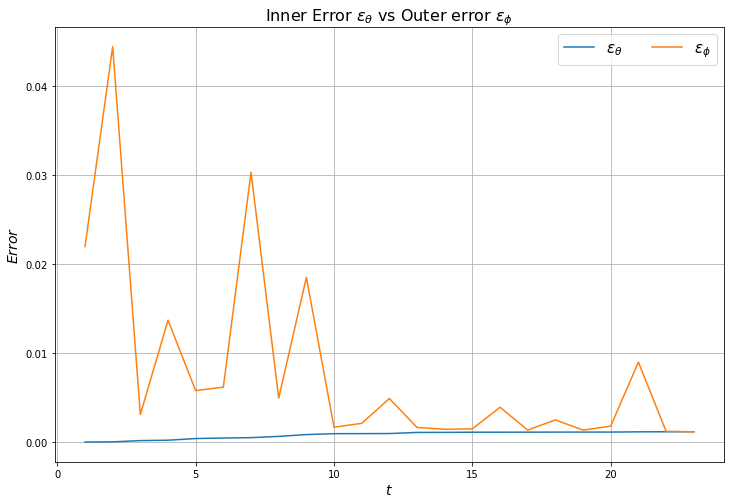

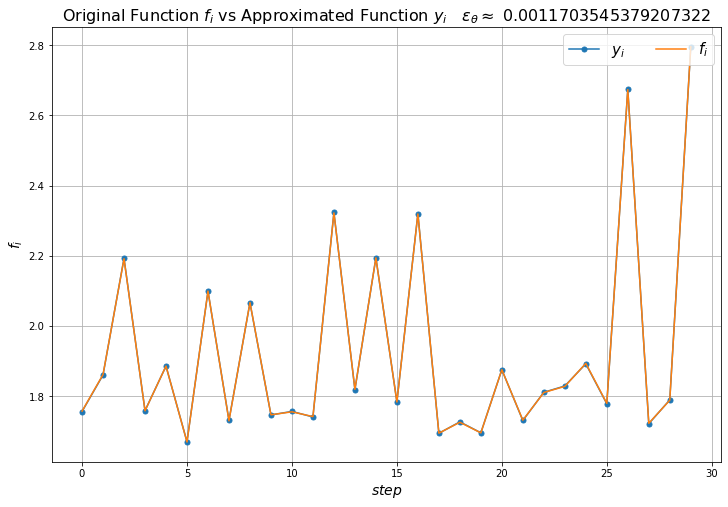


*** RESULTS ***
E_minimax: 	0.0011703545 
C[ 1]	 -1.8846596955 
C[ 2]	 -2.8822009047 
C[ 3]	 -1.3407728041 
C[ 4]	 -0.6326717739 
C[ 5]	 -2.9507242915 
C[ 6]	 -2.9611458237 
C[ 7]	 -0.4250899618 
C[ 8]	 -0.4155909282 
C[ 9]	 -0.6460664461 
C[10]	 -1.0532873036 
C[11]	 -0.0930076496 
C[12]	 -0.0474982307 

Execution time 	0.0092391968 s 
In the Results File the following will be written:
a) The coefficients the minimax error
b) Approximation and Original data



Give me the name for the Results File: 	 output_file.txt


In [69]:
## input del usuario
path = input('Input Data Filename: ')
delimiter = input("Input separator's type (, o tab): ")
# obtener grado de cada variable con la que se quiere aproximar    
d_variables = input("Input the list with the variables' largest degree. Example:[1,1,1]: ")
# convertir en lista de enteros d_variables
aux = list(d_variables.replace('[','').replace(']','').split(','))
degree_variables = [int(item) for item in aux]

## ejecutar funcion principal
_,_,_ = FAA(path,degree_variables,delimiter=delimiter)

Input Data Filename:  test_data.txt
Input separator's type (, o tab):  tab
Input the desired number for the model terms:  11
Input the maximum degree of every model monomial:  4


Monomials degrees:  ['401', '032', '000', '030', '311', '302', '132', '423', '202', '021', '111']


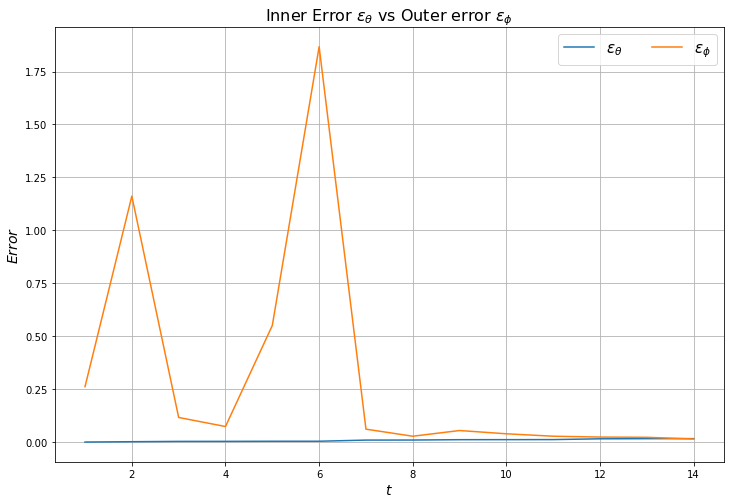

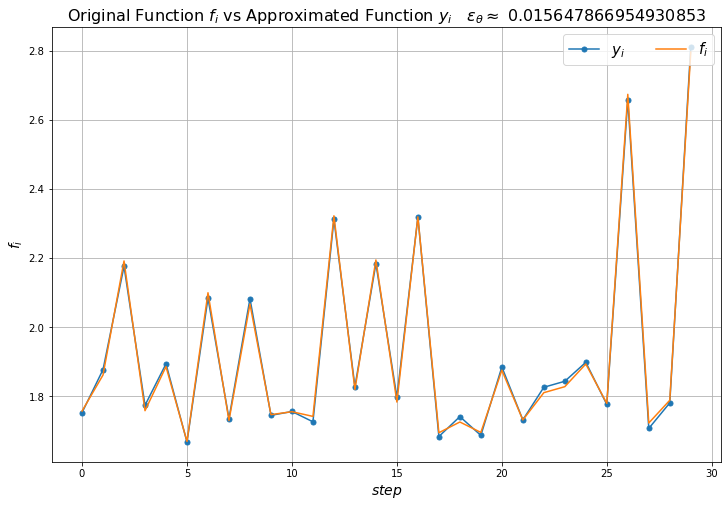


*** RESULTS ***
E_minimax: 	0.0156478670 
C[ 1]	 -0.0171812197 
C[ 2]	 0.0501074517 
C[ 3]	 1.1657881051 
C[ 4]	 0.1495611486 
C[ 5]	 -0.0543513325 
C[ 6]	 -0.1204998113 
C[ 7]	 0.0222669005 
C[ 8]	 -0.0005463614 
C[ 9]	 -0.0237057382 
C[10]	 0.3893552014 
C[11]	 0.0183777117 

Execution time 	0.0042753220 s 
In the Results File the following will be written:
a) The coefficients the minimax error
b) Approximation and Original data



Give me the name for the Results File: 	 ga_output_file.txt


In [82]:
## input del usuario
path = input('Input Data Filename: ')
delimiter = input("Input separator's type (, o tab): ")
# obtener grado de cada variable con la que se quiere aproximar    
model_terms = int(input("Input the desired number for the model terms: "))
max_degree = int(input("Input the maximum degree of every model monomial: "))
# convertir en lista de enteros d_variables
aux = list(d_variables.replace('[','').replace(']','').split(','))
degree_variables = [int(item) for item in aux]

## ejecutar funcion principal
coeffs_options = GAFAA(path,model_terms,max_degree,delimiter,iterations=256)